<a href="https://colab.research.google.com/github/blacktruth513/CodeStates_Project/blob/main/AI_03_%EC%B5%9C%ED%98%84%EC%A7%84_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# upload data(txt > df)
df_train = pd.read_table('/content/drive/MyDrive/AI_Bootcamp/Project1_Data/train.txt', sep='\t', header=None)
df_valid = pd.read_table('/content/drive/MyDrive/AI_Bootcamp/Project1_Data/dev.txt', sep='\t', header=None)
df_test = pd.read_table('/content/drive/MyDrive/AI_Bootcamp/Project1_Data/test.txt', sep='\t', header=None)

In [ ]:
df_train.columns = ['text', 'label']
df_valid.columns = ['text', 'label']
df_test.columns = ['text']

print(df_train)
print(df_valid)
print(df_test)

                             text label
0                 网易第三季度业绩低于分析师预期    科技
1       巴萨1年前地狱重现这次却是天堂 再赴魔鬼客场必翻盘    体育
2              美国称支持向朝鲜提供紧急人道主义援助    时政
3                增资交银康联 交行夺参股险商首单    股票
4                    午盘：原材料板块领涨大盘    股票
...                           ...   ...
752466     天津女排奇迹之源竟在场边 他是五冠王真正核心    体育
752467       北电网络专利拍卖推迟：可能分拆6部分拍卖    科技
752468  Spirit AeroSystems债券发行价确定    股票
752469    陆慧明必发火线：法兰克福无胜 曼联国米顺利过关    彩票
752470       首破万元 索尼46寸全新LED液晶特价促    科技

[752471 rows x 2 columns]
                           text label
0      网民市民集体幻想中奖后如果你中了9000万怎么办    彩票
1                   PVC期货有望5月挂牌    财经
2              午时三刻新作《幻神录―宿命情缘》    游戏
3          欧司朗LLFY网络提供一站式照明解决方案    家居
4         试探北京楼市向何方：排不完的队　涨不够的价    房产
...                         ...   ...
79995  王大雷看国足比赛预测比分我觉得是2-0或者3-1    体育
79996   克雷扎回归猛龙势如破竹希尔遭驱逐太阳惨败51分    体育
79997           王建宙将与台商共创4G网络商机    科技
79998      普京突访食品超市做调查不满高价猪肉(图)    时政
79999        高空俯视女明星性感乳沟(组图)(7)    时尚

[80000 rows x 2 columns]
           

In [ ]:
# EDA
# 학습 + 검증 데이터 병합 
df_total = pd.concat([df_train, df_valid], axis=0)

In [ ]:
# 타겟 데이터 분류 카테고리 확인 
df_total['label'].value_counts()

科技    162245
股票    153949
体育    130982
娱乐     92228
时政     62867
社会     50541
教育     41680
财经     36963
家居     32363
游戏     24283
房产     19922
时尚     13335
彩票      7598
星座      3515
Name: label, dtype: int64

In [ ]:
# 데이터 문서 길이 통계 분석 // 데이터 문서 최대 길이 = 48
df_total['text'].map(len).describe()

count    832471.000000
mean         19.388112
std           4.097139
min           2.000000
25%          17.000000
50%          20.000000
75%          23.000000
max          48.000000
Name: text, dtype: float64

In [ ]:
df_test['text'].map(len).describe()

count    83599.000000
mean        19.815022
std          3.883845
min          3.000000
25%         17.000000
50%         20.000000
75%         23.000000
max         84.000000
Name: text, dtype: float64

In [ ]:
df_train.to_csv('df_train.csv', sep='\t', index=False)
df_valid.to_csv('df_valid.csv', sep='\t', index=False)
df_test.to_csv('df_test.csv', sep='\t', index=False)

In [ ]:
# !pip install --upgrade paddlepaddle-gpu 
# !pip install --upgrade paddlenlp

In [ ]:
import math
import numpy as np
import os
import collections
from functools import partial
import random
import time
import inspect
import importlib
from tqdm import tqdm

# paddle-paddle
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import IterableDataset, Dataset
from paddlenlp.datasets import MapDataset
from paddlenlp.transformers import RobertaForSequenceClassification, RobertaTokenizer #pre-trained model 
from paddle.utils.download import get_path_from_url
import paddlenlp as ppnlp
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab
from paddlenlp.datasets import DatasetBuilder
from paddle.dataset.common import md5file
from paddlenlp.transformers import LinearDecayWithWarmup

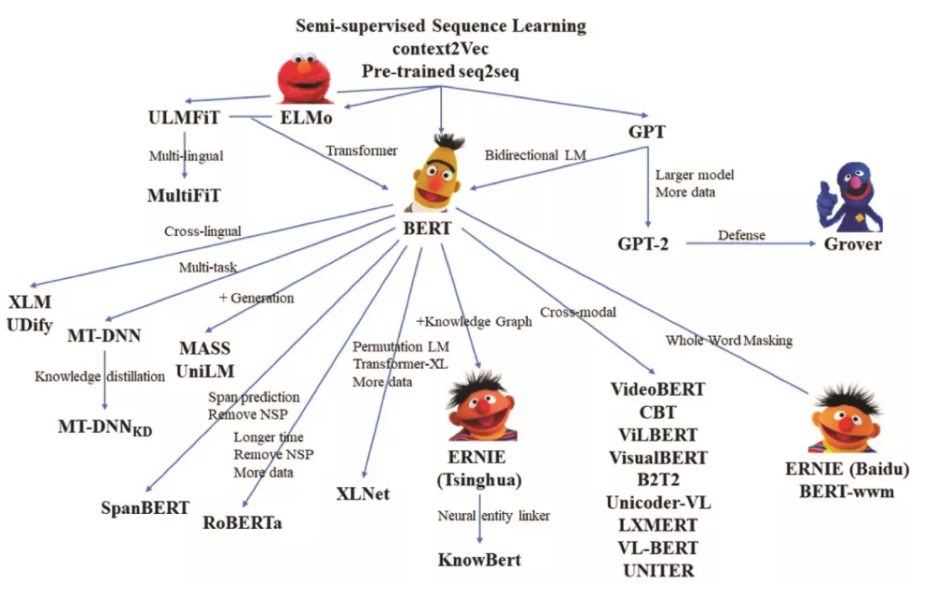

In [ ]:
# 전이학습(Pre-Trained Model)
MODEL_NAME = "roberta-wwm-ext-large"
model = ppnlp.transformers.RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# Robert 모델을 통한 토크나이징 실시
tokenizer = ppnlp.transformers.RobertaTokenizer.from_pretrained(MODEL_NAME)

[2021-10-21 13:28:34,941] [    INFO] - Already cached /root/.paddlenlp/models/roberta-wwm-ext-large/roberta_chn_large.pdparams
[2021-10-21 13:28:41,954] [    INFO] - Already cached /root/.paddlenlp/models/roberta-wwm-ext-large/vocab.txt


In [ ]:
labels = list(df_train.label.unique())
print(labels)

['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']


In [ ]:
# 데이터셋 / 데이터 변수 자료형 저장 함수
class NewsData(DatasetBuilder):
    splits = {
        'train': 'df_train.csv',  
        'valid': 'df_valid.csv'}
    
    def _get_data(self, mode, **kwargs):
        filename = self.splits[mode]
        return filename

    def _read(self, filename):
        #load data
        with open(filename, 'r', encoding='utf-8') as f:
            head = None
            for line in f:
                data = line.strip().split("\t")   
                if not head:
                    head = data
                else:
                    text, label = data
                    yield {"text": text, "label": label} 
    def get_labels(self):
        return labels   

In [ ]:
# 데이터셋 함수화
def load_dataset(name=None,
                 data_files=None,
                 splits=None,
                 lazy=None,
                 **kwargs):
   
    reader_cls = NewsData  
    print(reader_cls)
    if not name:
        reader_instance = reader_cls(lazy=lazy, **kwargs)
    else:
        reader_instance = reader_cls(lazy=lazy, name=name, **kwargs)

    datasets = reader_instance.read_datasets(data_files=data_files, splits=splits)
    
    return datasets

In [ ]:
df_train, df_valid = load_dataset(splits=["train", "valid"])

<class '__main__.NewsData'>


In [ ]:
# 딥러닝 프레임워크용 데이터 변형
def create_dataloader(dataset,
                      mode='train',
                      batch_size=1,
                      batchify_fn=None,
                      trans_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn)

    shuffle = True if mode == 'train' else False

    # 데이터 셔플 
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset=dataset, batch_size=batch_size, shuffle=True)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset=dataset, batch_size=batch_size, shuffle=shuffle)

    dataloader = paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=batch_sampler,
        #return_list=True,
        collate_fn=batchify_fn)
    
    return dataloader

def convert_example(example, tokenizer, max_seq_length=48, is_test=False):
    qtconcat = example['text']
    encoded_inputs = tokenizer(text=qtconcat, max_seq_len=max_seq_length)  
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids

In [ ]:
# 배치사이즈 
batch_size = 16
max_seq_length = 48

trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack()  # labels
): [data for data in fn(samples)]

# 훈련 데이터셋
train_data_loader = create_dataloader(
    df_train,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

# 검증 데이터셋
dev_data_loader = create_dataloader(
    df_valid,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

In [ ]:
#하이퍼파라미터, 로스함수, 최적화 함수 정의
epochs = 1
learning_rate = 2e-5

# # 学习率预热比例
# warmup_proportion = 0.1
# # 权重衰减系数，类似模型正则项策略，避免模型过拟合
# weight_decay = 0.01
# num_training_steps = len(train_data_loader) * epochs
# lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)

optimizer = paddle.optimizer.AdamW(
    learning_rate=learning_rate,
    parameters=model.parameters())

criterion = paddle.nn.loss.CrossEntropyLoss()

metric = paddle.metric.Accuracy()           

In [ ]:
# 성능 평가 함수 
@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu)) 
    model.train()
    metric.reset()
    return accu  

In [ ]:
# 랜덤시드 고정
seed = 1024 
random.seed(1024)
np.random.seed(1024)
paddle.seed(1024)

In [ ]:
# 학습/검증 데이터 적용 모델링
save_dir = "checkpoint"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

pre_accu=0
accu=0
global_step = 0
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels) # 로스함수
        probs = F.softmax(logits, axis=1) # 소프트맥스 다중분류함수
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        if global_step % 100 == 0 :
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        #lr_scheduler.step()
        optimizer.clear_grad()
        
    # epch 종료시 검증 데이터 평가
    accu = evaluate(model, criterion, metric, dev_data_loader)
    print(accu)
    
    if accu > pre_accu:
        save_param_path = os.path.join(save_dir, 'model_state.pdparams')  
        paddle.save(model.state_dict(), save_param_path)
        pre_accu=accu    
tokenizer.save_pretrained(save_dir)

global step 100, epoch: 1, batch: 100, loss: 1.08459, acc: 0.73125
global step 200, epoch: 1, batch: 200, loss: 0.06354, acc: 0.80688
global step 300, epoch: 1, batch: 300, loss: 0.27519, acc: 0.83333
global step 400, epoch: 1, batch: 400, loss: 0.69796, acc: 0.84984
global step 500, epoch: 1, batch: 500, loss: 0.92420, acc: 0.85913
global step 600, epoch: 1, batch: 600, loss: 0.51070, acc: 0.86583
global step 700, epoch: 1, batch: 700, loss: 0.07620, acc: 0.87125
global step 800, epoch: 1, batch: 800, loss: 0.02231, acc: 0.87813
global step 900, epoch: 1, batch: 900, loss: 0.36633, acc: 0.88222
global step 1000, epoch: 1, batch: 1000, loss: 0.24343, acc: 0.88606
global step 1100, epoch: 1, batch: 1100, loss: 0.05819, acc: 0.88858
global step 1200, epoch: 1, batch: 1200, loss: 0.49443, acc: 0.89104
global step 1300, epoch: 1, batch: 1300, loss: 0.08104, acc: 0.89236
global step 1400, epoch: 1, batch: 1400, loss: 0.51495, acc: 0.89509
global step 1500, epoch: 1, batch: 1500, loss: 0.026

In [ ]:
# 최종모델 업로드 (예측 모델 적용)          
params_path = 'checkpoint/model_state.pdparams'        
if params_path and os.path.isfile(params_path):  
    state_dict = paddle.load(params_path)
    model.set_dict(state_dict)
    print("Loaded parameters from %s" % params_path)

Loaded parameters from checkpoint/model_state.pdparams


In [ ]:
# 검증데이터 평가 
evaluate(model, criterion, metric, dev_data_loader)

eval loss: 0.11553, accu: 0.96206


0.9620625

In [ ]:
#모델 예측(테스트 데이터 적용)
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    # 모델에 적용하기 위한 테스트데이터 함수화 
    for text in data:
        input_ids, segment_ids = convert_example(
            text,
            tokenizer,
            max_seq_length=48,
            is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)

    # cf) Seperates data into some batches.
    batches = []
    one_batch = []
    for example in examples:
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        # cf) The last batch whose size is less than the config batch_size setting.
        batches.append(one_batch)

    results = []
    model.eval()
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        labels = [label_map[i] for i in idx]
        results.extend(labels)
    return results  

In [ ]:
# 테스트 데이터 적용 라벨(리스트) 맵
label_map = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}
print(label_map)

{0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}


In [ ]:
# 테스트데이터 df화
df_test = pd.read_csv('./df_test.csv', sep='\t')  
df_test

,text
0,北京君太百货璀璨秋色 满100省353020元
1,教育部：小学高年级将开始学习性知识
2,专业级单反相机 佳能7D单机售价9280元
3,星展银行起诉内地客户 银行强硬客户无奈
4,脱离中国的实际 强压人民币大幅升值只能是梦想
...,...
83594,Razer杯DotA精英挑战赛8月震撼登场
83595,经济数据好转吹散人民币贬值预期
83596,抵押率抵押物双控政策 刘明康支招房产贷款
83597,8000万像素 利图发布Aptus-II 12数码后背


In [ ]:
# 예측모델에 적용하기 위한 테스트데이터 전처리
def preprocess_prediction_data(data):
    examples = []
    for text in data:
        examples.append({"text": text})
    return examples

test_data = df_test['text']
df_test = preprocess_prediction_data(test_data)

In [ ]:
# 테스트 데이터 모델링
results = predict(model, df_test, tokenizer, label_map, batch_size=16)

In [ ]:
# 예측 결과 txt 문서화
def write_results(labels, file_path):
    with open(file_path, "w", encoding="utf8") as f:
        f.writelines("\n".join(labels))

write_results(results, "/content/drive/MyDrive/AI_Bootcamp/Project1_Data/result.txt")

In [ ]:
df_test2 = pd.read_table('/content/drive/MyDrive/AI_Bootcamp/Project1_Data/test.txt', sep='\t', header=None)
df_test2.columns = ['text']
print(df_test2)

                              text
0          北京君太百货璀璨秋色 满100省353020元
1                教育部：小学高年级将开始学习性知识
2            专业级单反相机 佳能7D单机售价9280元
3              星展银行起诉内地客户 银行强硬客户无奈
4           脱离中国的实际 强压人民币大幅升值只能是梦想
...                            ...
83594        Razer杯DotA精英挑战赛8月震撼登场
83595              经济数据好转吹散人民币贬值预期
83596         抵押率抵押物双控政策 刘明康支招房产贷款
83597  8000万像素 利图发布Aptus-II 12数码后背
83598          教育部公布33个国家万余所正规学校名单

[83599 rows x 1 columns]


In [ ]:
results = pd.read_table("/content/drive/MyDrive/AI_Bootcamp/Project1_Data/result.txt", sep='\t', header=None)
results.columns = ['label']
print(results)

      label
0        家居
1        时政
2        科技
3        股票
4        股票
...     ...
83594    游戏
83595    股票
83596    房产
83597    科技
83598    教育

[83599 rows x 1 columns]


In [ ]:
test_predict = pd.concat([df_test2, results],axis=1)
print(test_predict)

                              text label
0          北京君太百货璀璨秋色 满100省353020元    家居
1                教育部：小学高年级将开始学习性知识    时政
2            专业级单反相机 佳能7D单机售价9280元    科技
3              星展银行起诉内地客户 银行强硬客户无奈    股票
4           脱离中国的实际 强压人民币大幅升值只能是梦想    股票
...                            ...   ...
83594        Razer杯DotA精英挑战赛8月震撼登场    游戏
83595              经济数据好转吹散人民币贬值预期    股票
83596         抵押率抵押物双控政策 刘明康支招房产贷款    房产
83597  8000万像素 利图发布Aptus-II 12数码后背    科技
83598          教育部公布33个国家万余所正规学校名单    教育

[83599 rows x 2 columns]


In [ ]:
test_predict.to_csv('test_predict.csv', sep='\t', index=False)
print(test_predict)

                              text label
0          北京君太百货璀璨秋色 满100省353020元    家居
1                教育部：小学高年级将开始学习性知识    时政
2            专业级单反相机 佳能7D单机售价9280元    科技
3              星展银行起诉内地客户 银行强硬客户无奈    股票
4           脱离中国的实际 强压人民币大幅升值只能是梦想    股票
...                            ...   ...
83594        Razer杯DotA精英挑战赛8月震撼登场    游戏
83595              经济数据好转吹散人民币贬值预期    股票
83596         抵押率抵押物双控政策 刘明康支招房产贷款    房产
83597  8000万像素 利图发布Aptus-II 12数码后背    科技
83598          教育部公布33个国家万余所正规学校名单    教育

[83599 rows x 2 columns]


In [ ]:
test_predict.to_csv('test_predict.txt', sep = '\t')
test_predict.head(50)

,text,label
0,北京君太百货璀璨秋色 满100省353020元,家居
1,教育部：小学高年级将开始学习性知识,时政
2,专业级单反相机 佳能7D单机售价9280元,科技
3,星展银行起诉内地客户 银行强硬客户无奈,股票
4,脱离中国的实际 强压人民币大幅升值只能是梦想,股票
5,内城土地稀缺 对开发商提出更高要求(组图),房产
6,亚欧首脑会议举行第二次全体会议(组图),时政
7,荷兰主帅球迷面前表决心耍酷 罗本不在范佩西成一哥,体育
8,搭配18-105VR镜头 尼康D90带票7109元,科技
9,百盛购物中心美罗城店 同一专柜花120得200,家居


In [ ]:
test_predict = pd.DataFrame(test_predict)
test_predict.to_csv('/content/drive/MyDrive/AI_Bootcamp/Project1_Data/test_predict.csv', header=False, index=True)